# COGS 108 - EDA Checkpoint

# Names

- Jamie Wei
- Alexis Garduno
- James Daza
- Aleksander Archipov

<a id='research_question'></a>
# Research Question

- Does the number of times a player is traded predict that player's performance (e.g. average total points scored/game, average minutes played/game, etc) in an NBA game? Also, does the turn-over rate (e.g. number of players traded within a team/season) of a NBA team affect the likelihood that the team will reach the NBA finals (evidenced by the last 20 years of NBA games)?

# Dataset(s)

- Dataset Name: nba_api (replace with the dataset we generated from nba_api) 
- Link to the dataset: https://github.com/swar/nba_api
- Number of observations: N/A
    - API Client that allows access to various NBA's stats API endpoints

- Dataset Name: NBA Stats (replace with boxscore and team performance datasets)
- Link to the dataset: https://www.nba.com/stats/
- Number of observations: 12
    - Player stats from 10 random teams ranging from 2016-2021


# Setup

In [40]:
#data wrangling, etc
import pandas as pd
import numpy as np
import time

#import datasets
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats

#graphic packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import rankdata

### Gathering Teams

In [41]:
#Import the roster of teams from the NBA API
from nba_api.stats.static import teams

nba_teams = teams.get_teams()

We select 10 nba teams at random 

In [42]:
#Obtain a full list of all abbreviations - will need abbreviations to identify team statistics
nba_teams_df=pd.DataFrame(nba_teams)
team_id=nba_teams_df['id'] #this is the unique team id
team_id_random=np.random.choice(team_id,10,replace=False) #identify ten team ids
nba_teams_rdf=nba_teams_df[nba_teams_df['id'].isin(team_id_random)] #df of 10 randomly selected teams
nba_teams_rdf

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
5,1610612742,Dallas Mavericks,DAL,Mavericks,Dallas,Texas,1980
7,1610612744,Golden State Warriors,GSW,Warriors,Golden State,California,1946
8,1610612745,Houston Rockets,HOU,Rockets,Houston,Texas,1967
14,1610612751,Brooklyn Nets,BKN,Nets,Brooklyn,New York,1976
24,1610612761,Toronto Raptors,TOR,Raptors,Toronto,Ontario,1995
26,1610612763,Memphis Grizzlies,MEM,Grizzlies,Memphis,Tennessee,1995
28,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,1948


### Requesting Games
Now we request the games for all of the ten teams we have selected

In [43]:
#Pull all games for all ten teams

#Documentation for this endpoint: 
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguegamefinder.md
from nba_api.stats.endpoints import leaguegamefinder

# Query for games from the League Game Finder
gamefinder=pd.DataFrame()
for i in team_id_random:
    time.sleep(1) #delay to prevent being blocked from the API
    df = leaguegamefinder.LeagueGameFinder(team_id_nullable=[i]).get_data_frames()[0] #parameter of team ids given
    gamefinder = pd.concat([df,gamefinder])

In [44]:
#Game Statistics

#One row corresponds to one game and one team.
#There will be two rows per game, since there are two teams that played each other.
#Will need to exclude duplicate rows (XXXX will remove duplicate rows)
print(list(set(gamefinder.TEAM_ID))) #confirmed that identified 10 different teams
print(gamefinder.shape) #31,386 games

##Game Finder Dataset: This dataset will be used as the outcome when we look at the association between 
##the exposure and outcome relationship. 
gamefinder

[1610612737, 1610612738, 1610612740, 1610612742, 1610612744, 1610612745, 1610612751, 1610612761, 1610612763, 1610612765]
(31243, 28)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22021,1610612745,HOU,Houston Rockets,0022100888,2022-02-17,HOU @ LAC,L,240,111,...,0.737,12.0,23.0,35.0,29,8.0,2,18,20,-31.0
1,22021,1610612745,HOU,Houston Rockets,0022100882,2022-02-16,HOU @ PHX,L,240,121,...,0.857,13.0,36.0,49.0,23,5.0,5,16,27,-3.0
2,22021,1610612745,HOU,Houston Rockets,0022100865,2022-02-14,HOU @ UTA,L,239,101,...,0.679,10.0,23.0,33.0,23,5.0,4,12,20,-34.0
3,22021,1610612745,HOU,Houston Rockets,0022100834,2022-02-10,HOU vs. TOR,L,240,120,...,0.600,13.0,28.0,41.0,25,5.0,4,21,20,-19.0
4,22021,1610612745,HOU,Houston Rockets,0022100819,2022-02-08,HOU @ NOP,L,240,97,...,0.645,18.0,29.0,47.0,19,8.0,3,21,23,-13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399,21995,1610612763,VAN,Vancouver Grizzlies,0029500057,1995-11-10,VAN vs. LAC,L,240,91,...,0.857,6.0,23.0,29.0,22,14.0,7,23,28,NaN
2400,21995,1610612763,VAN,Vancouver Grizzlies,0029500050,1995-11-08,VAN @ SAN,L,240,62,...,0.692,18.0,29.0,47.0,8,4.0,3,23,26,NaN
2401,21995,1610612763,VAN,Vancouver Grizzlies,0029500031,1995-11-07,VAN @ DAL,L,240,88,...,0.741,9.0,26.0,35.0,18,10.0,5,14,15,NaN
2402,21995,1610612763,VAN,Vancouver Grizzlies,0029500026,1995-11-05,VAN vs. MIN,W,265,100,...,0.625,19.0,34.0,53.0,21,10.0,7,19,24,NaN


Now we request all the player stats from seasons ranging from 2016-2021

In [45]:
#get game ids for the last five years

#for now, let's focus on the last five seasons for ease
from nba_api.stats.endpoints import playergamelogs

#generate a parameter dataframe to define timeframe
#Is this timeframe correct? What is the timeframe that the season normally runs from?
season_parameter_df=pd.DataFrame({'Season':['2016-17','2017-18','2018-19','2019-20','2020-21'], 
                    'Date_From':['9/01/2016','9/01/2017','9/01/2018','9/01/2019','9/01/2020'],
                    'Date_To':['8/31/2017','8/31/2018','8/31/2019','8/31/2020','8/31/2021']})

#will obtain no game ids, without the season_nullable and date_nullable items selected
logsdf=pd.DataFrame()
for i in list(range(1, 5)):
    time.sleep(1)
    season=season_parameter_df.iloc[i][0]
    date_from=season_parameter_df.iloc[i][1]
    date_to=season_parameter_df.iloc[i][2]
    
    logs = pd.DataFrame(playergamelogs.PlayerGameLogs(
        season_nullable = season,
        date_from_nullable = date_from,                                                     
        date_to_nullable = date_to
    ).player_game_logs.get_data_frame())
    logsdf = pd.concat([logs,logsdf])

In [46]:
#unique set of game ids
game_ids = list(set(logsdf['GAME_ID'])) #not sure if we need game_ids
player_ids = pd.DataFrame(list(set(logsdf['PLAYER_ID'])))
print(pd.DataFrame(game_ids).shape) #4599 game ids
print(player_ids.shape) #875 unique players
print(logsdf.shape) #97,655 rows where each row is for each player in each game. 

(4599, 1)
(875, 1)
(97655, 66)


<b>4599 Games <br>
875 Unique Players <br>
97,655 stats of players in each game<b>

All the columns of every player that played in the seasons we selected from the random teams chosen

In [47]:
#preview, likely not use these columns
logsdf.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2',
       'TD3', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK',
       'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
       'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK',
       'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK',
       'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

# Dataset

### Manipulating/Plotting CSV File Data

In [48]:
import seaborn as sns

In [49]:
#Need to plot the distributions data using either seaborn or matplotlib

dataDf = pd.read_csv("logPlayerStats.csv")
dataDf['TIMES_TRADED'] = np.nan
pid_lst = list(player_ids[0])
pid_lst[0]

for pid in pid_lst:
    tempDf = dataDf[dataDf['PLAYER_ID'] == pid]
    traded = len(pd.unique(tempDf['TEAM_NAME']))-1
    dataDf.loc[dataDf['PLAYER_ID'] == pid, 'TIMES_TRADED'] = int(traded)

dataDf[dataDf['TIMES_TRADED'] >= 3]
    

,Unnamed: 0,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,MIN,FG_PCT,FT_PCT,PTS,AST,REB,STL,BLK,PLUS_MINUS,TIMES_TRADED
78,253,2020-21,203953,Jabari Parker,1610612738,Boston Celtics,26.900000,0.600,0.833,18,2,7,0,0,8,3.0
110,326,2020-21,203953,Jabari Parker,1610612738,Boston Celtics,17.483333,0.500,0.667,9,2,3,0,0,-10,3.0
624,1775,2020-21,203953,Jabari Parker,1610612738,Boston Celtics,9.583333,0.500,0.000,4,0,2,0,1,-10,3.0
687,2016,2020-21,203953,Jabari Parker,1610612738,Boston Celtics,8.150000,0.500,0.000,2,0,5,0,0,6,3.0
1168,3479,2020-21,203953,Jabari Parker,1610612738,Boston Celtics,4.700000,0.000,0.000,0,0,1,0,0,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32277,24640,2017-18,202328,Greg Monroe,1610612749,Milwaukee Bucks,17.208333,0.500,0.000,8,1,6,0,0,-1,3.0
32463,25213,2017-18,202328,Greg Monroe,1610612749,Milwaukee Bucks,20.500000,0.444,0.000,8,3,7,0,0,5,3.0
32506,25369,2017-18,202328,Greg Monroe,1610612749,Milwaukee Bucks,6.733333,0.000,0.000,0,0,0,0,0,-3,3.0
32659,25757,2017-18,202328,Greg Monroe,1610612749,Milwaukee Bucks,18.133333,0.500,0.000,8,0,6,0,0,-15,3.0


### Ranking Data Reflecting Overall Team Performance

In [50]:
#list unique names of teams
list(set(dataDf.get('TEAM_NAME')))

['Philadelphia 76ers',
 'Sacramento Kings',
 'Minnesota Timberwolves',
 'Phoenix Suns',
 'Milwaukee Bucks',
 'Boston Celtics',
 'Chicago Bulls',
 'Golden State Warriors',
 'Orlando Magic',
 'San Antonio Spurs']

In [51]:
#import the NBA team ranks to reflect overall performance
NBA_team_rank=pd.read_csv("NBAstanding.csv")
#dictionary to facilitate merging the player-level information with team ranking information
team_dict = {'76ers':'Philadelphia 76ers','Kings': 'Sacramento Kings',
             'Minnesota Timberwolves':'	Timberwolves','Suns':'Phoenix Suns',
             'Bucks': 'Milwaukee Bucks','Celtics':'Boston Celtics',
             'Bulls':'Chicago Bulls','Warriors':'Golden State Warriors','Magic':'Orlando Magic',
             'Spurs':'San Antonio Spurs'}
#replace values for roster with key
NBA_team_rank.replace({"Team_Name": team_dict},inplace=True)
#restrict to teams listed in the roster
NBA_team_rank=NBA_team_rank[NBA_team_rank['Team_Name'].isin(list(set(dataDf.get('TEAM_NAME'))))]
NBA_team_rank

,Team_Name,Wins_2022,PCT_2022,Wins_2021,PCT_2021,Wins_2020,PCT_2020,Wins_2019,PCT_2019,Wins_2018,...,Wins_2017,PCT_2017,Wins_2016,PCT_2016,Wins_2015,PCT_2015,Wins_2014,PCT_2014,Wins_2013,PCT_2013
1,Chicago Bulls,38.0,64.0,31.0,43.0,22.0,34.0,22.0,27.0,44.0,...,41.0,50.0,42.0,51.0,50.0,61.0,48.0,59.0,45.0,55.0
2,Philadelphia 76ers,35.0,60.0,49.0,68.0,43.0,59.0,51.0,62.0,52.0,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
4,Milwaukee Bucks,36.0,60.0,46.0,64.0,56.0,76.0,60.0,73.0,44.0,...,42.0,51.0,33.0,40.0,41.0,50.0,15.0,18.0,38.0,46.0
5,Boston Celtics,34.0,57.0,36.0,50.0,48.0,66.0,49.0,60.0,55.0,...,53.0,65.0,48.0,59.0,40.0,49.0,25.0,30.0,41.0,51.0
14,Orlando Magic,13.0,21.0,21.0,29.0,33.0,45.0,42.0,51.0,25.0,...,29.0,35.0,35.0,43.0,25.0,30.0,23.0,28.0,20.0,24.0
15,Phoenix Suns,48.0,83.0,51.0,70.0,34.0,46.0,19.0,23.0,21.0,...,24.0,29.0,23.0,28.0,39.0,48.0,48.0,59.0,25.0,31.0
16,Golden State Warriors,42.0,71.0,39.0,54.0,15.0,23.0,57.0,69.0,58.0,...,67.0,81.0,73.0,89.0,67.0,82.0,51.0,62.0,47.0,57.0
25,San Antonio Spurs,23.0,39.0,33.0,46.0,32.0,45.0,48.0,59.0,47.0,...,61.0,74.0,67.0,82.0,55.0,67.0,62.0,76.0,58.0,71.0
27,Sacramento Kings,22.0,37.0,31.0,43.0,31.0,43.0,39.0,48.0,27.0,...,32.0,39.0,33.0,40.0,29.0,25.0,28.0,34.0,28.0,34.0


### Data Analysis & Results (EDA)

In [85]:
#merge the datasets
dataDfm=dataDf.merge(NBA_team_rank, left_on='TEAM_NAME', right_on='Team_Name')
#check that the dimension of the data frame has not changed
print(dataDf.shape)
print(dataDfm.shape)
dataDfm

(32780, 16)
(29646, 37)


,Unnamed: 0,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,MIN,FG_PCT,FT_PCT,PTS,...,Wins_2017,PCT_2017,Wins_2016,PCT_2016,Wins_2015,PCT_2015,Wins_2014,PCT_2014,Wins_2013,PCT_2013
0,1,2020-21,1629003,Shake Milton,1610612755,Philadelphia 76ers,25.600000,0.462,0.00,15,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
1,8,2020-21,203118,Mike Scott,1610612755,Philadelphia 76ers,25.166667,0.250,0.00,5,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
2,88,2020-21,2730,Dwight Howard,1610612755,Philadelphia 76ers,17.050000,0.500,0.50,5,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
3,114,2020-21,1630194,Paul Reed,1610612755,Philadelphia 76ers,23.533333,0.538,0.75,17,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
4,119,2020-21,1629109,Gary Clark,1610612755,Philadelphia 76ers,8.833333,0.000,0.00,0,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29641,25976,2017-18,1627781,Malachi Richardson,1610612758,Sacramento Kings,5.533333,0.000,0.00,0,...,32.0,39.0,33.0,40.0,29.0,25.0,28.0,34.0,28.0,34.0
29642,25979,2017-18,1713,Vince Carter,1610612758,Sacramento Kings,14.183333,0.667,0.00,6,...,32.0,39.0,33.0,40.0,29.0,25.0,28.0,34.0,28.0,34.0
29643,26006,2017-18,1627746,Skal Labissiere,1610612758,Sacramento Kings,32.761667,0.556,1.00,12,...,32.0,39.0,33.0,40.0,29.0,25.0,28.0,34.0,28.0,34.0
29644,26021,2017-18,201585,Kosta Koufos,1610612758,Sacramento Kings,17.550000,0.250,0.00,2,...,32.0,39.0,33.0,40.0,29.0,25.0,28.0,34.0,28.0,34.0


## Summary Statistics 

- We are investigating the extent to which a player was traded over an annual basis. Out of all players over the last five seasons, the average player was traded **XX%**. 
- Add more description @Jaimie; interpret the text for this.

In [84]:
#Times traded has duplicated measures of times traded for the team
#Deduplication only has unique information for each team and for each season. 
dataDfm_dedup=dataDfm.drop_duplicates(subset=['TEAM_NAME','TIMES_TRADED','SEASON_YEAR'])
dataDfm_dedup.get(['TEAM_NAME','TIMES_TRADED','SEASON_YEAR'])

,TEAM_NAME,TIMES_TRADED,SEASON_YEAR
0,Philadelphia 76ers,0.0,2020-21
4,Philadelphia 76ers,1.0,2020-21
5,Philadelphia 76ers,2.0,2020-21
829,Philadelphia 76ers,0.0,2019-20
830,Philadelphia 76ers,2.0,2019-20
...,...,...,...
27906,Sacramento Kings,1.0,2018-19
27914,Sacramento Kings,2.0,2018-19
28781,Sacramento Kings,1.0,2017-18
28783,Sacramento Kings,0.0,2017-18


In [83]:
#Examine the number of times traded per team
print(dataDfm_dedup.mean().get('TIMES_TRADED'))
print(dataDfm_dedup.groupby(['SEASON_YEAR']).mean().get('TIMES_TRADED').reset_index())
print(dataDfm_dedup.groupby(['TEAM_NAME']).mean().get('TIMES_TRADED').reset_index())
average_team_trades=dataDfm_dedup.groupby(['TEAM_NAME','SEASON_YEAR']).mean().get('TIMES_TRADED').reset_index()
average_team_trades.sort_values("TIMES_TRADED",ascending=False)

1.0198019801980198
  SEASON_YEAR  TIMES_TRADED
0     2017-18      1.040000
1     2018-19      1.076923
2     2019-20      0.916667
3     2020-21      1.038462
               TEAM_NAME  TIMES_TRADED
0         Boston Celtics      1.250000
1          Chicago Bulls      0.777778
2  Golden State Warriors      0.909091
3        Milwaukee Bucks      1.083333
4          Orlando Magic      0.666667
5     Philadelphia 76ers      1.153846
6           Phoenix Suns      1.153846
7       Sacramento Kings      1.285714
8      San Antonio Spurs      0.500000


,TEAM_NAME,SEASON_YEAR,TIMES_TRADED
3,Boston Celtics,2020-21,1.500000
24,Phoenix Suns,2017-18,1.500000
31,Sacramento Kings,2020-21,1.500000
21,Philadelphia 76ers,2018-19,1.500000
30,Sacramento Kings,2019-20,1.500000
0,Boston Celtics,2017-18,1.333333
5,Chicago Bulls,2018-19,1.333333
12,Milwaukee Bucks,2017-18,1.333333
1,Boston Celtics,2018-19,1.333333
29,Sacramento Kings,2018-19,1.000000


###  Data Distribution of Player Performance Metrics (Overall)

@Jaimie, please write a key for what these figures are and generally describe distributions. Please describe what these measures mean for overall sport's performances or trends that you notice in game metrics.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72ec3a9b10>,
      dtype=object)

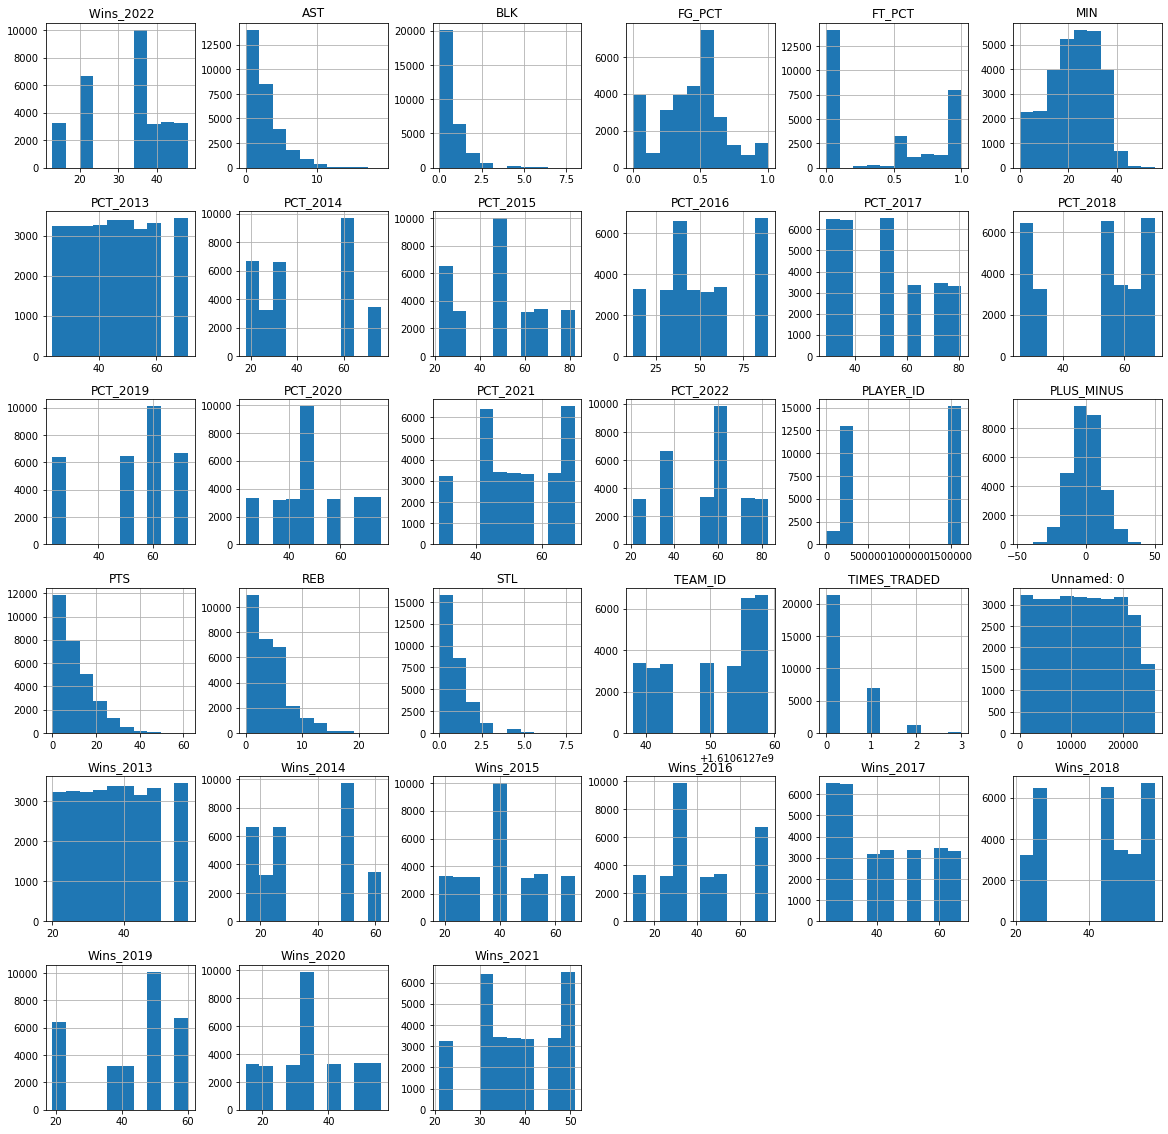

In [188]:
dataDfm.hist(figsize=(20,20))

### Player Distribution of Player Trades Per Team over 5 Seasons

Boston Celtics                AxesSubplot(0.1,0.679412;0.235294x0.220588)
Chicago Bulls            AxesSubplot(0.382353,0.679412;0.235294x0.220588)
Golden State Warriors    AxesSubplot(0.664706,0.679412;0.235294x0.220588)
Milwaukee Bucks               AxesSubplot(0.1,0.414706;0.235294x0.220588)
Orlando Magic            AxesSubplot(0.382353,0.414706;0.235294x0.220588)
Philadelphia 76ers       AxesSubplot(0.664706,0.414706;0.235294x0.220588)
Phoenix Suns                      AxesSubplot(0.1,0.15;0.235294x0.220588)
Sacramento Kings             AxesSubplot(0.382353,0.15;0.235294x0.220588)
San Antonio Spurs            AxesSubplot(0.664706,0.15;0.235294x0.220588)
dtype: object

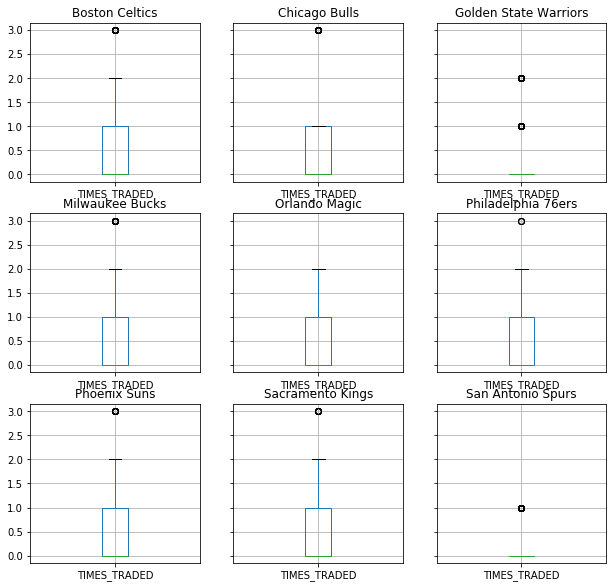

In [189]:
dataDfm.get(['TEAM_NAME','TIMES_TRADED']).groupby(['TEAM_NAME']).boxplot(figsize=(10,10))

<IPython.core.display.Javascript object>


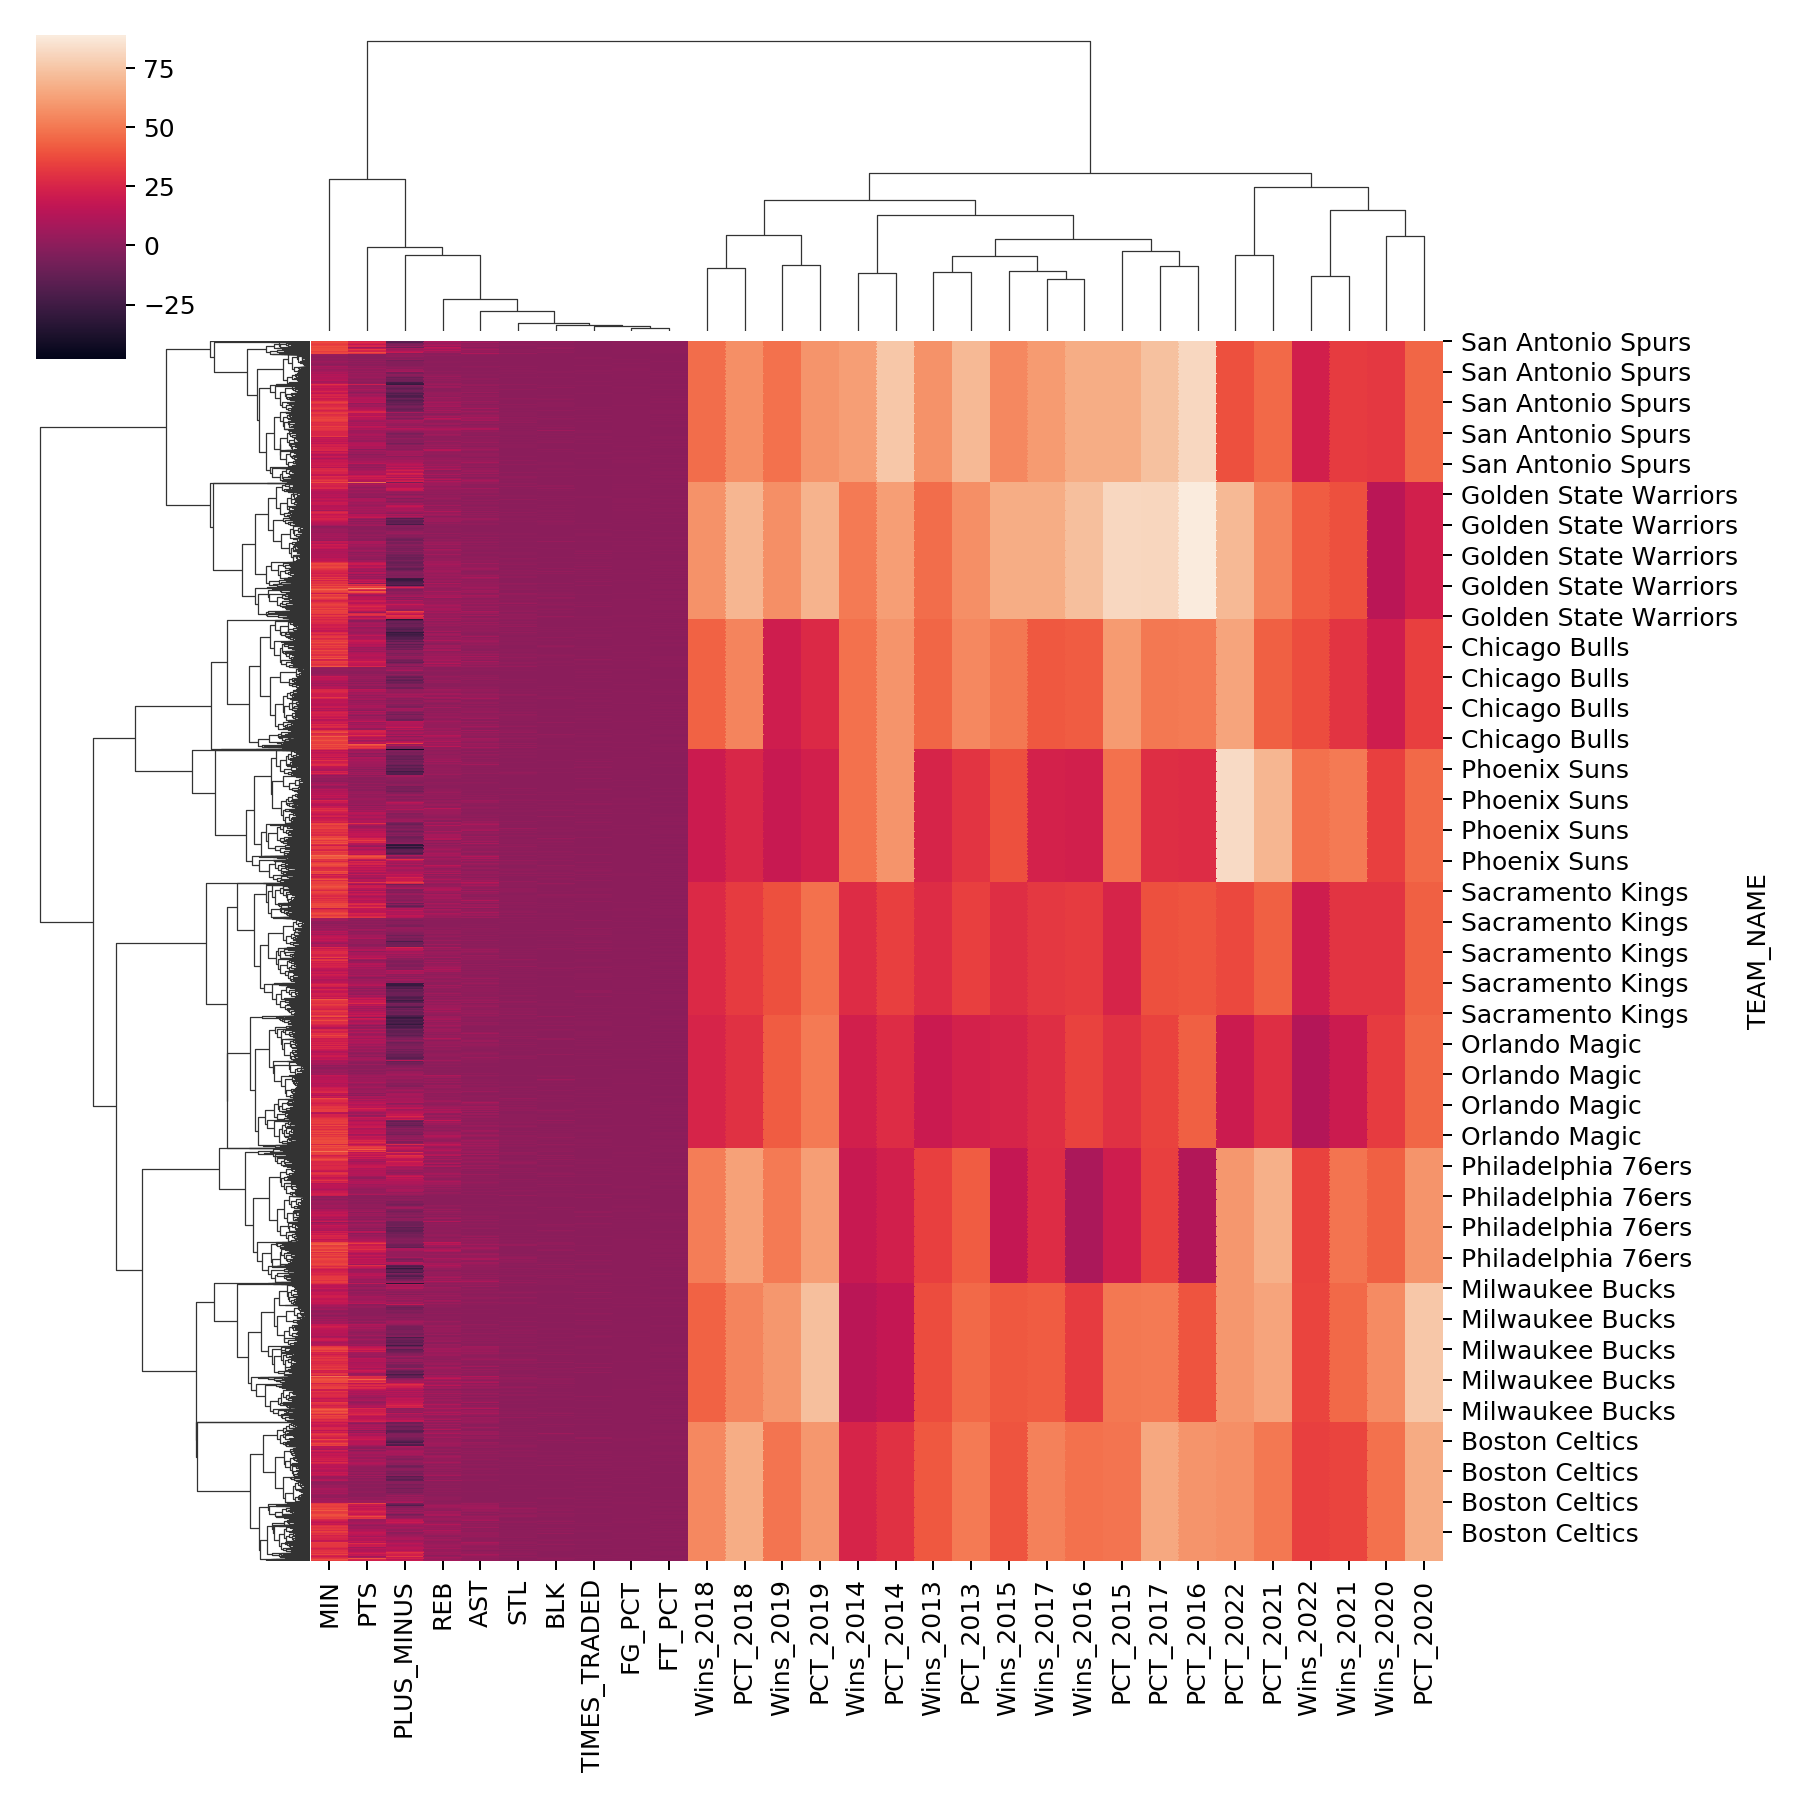

In [236]:
%matplotlib notebook
df = dataDfm
df = df.set_index('TEAM_NAME')
sns.clustermap(df.drop(columns=['TEAM_ID','PLAYER_ID','Unnamed: 0']).select_dtypes(include= np.number))
plt.show()

In [233]:
df.columns

Index(['Unnamed: 0', 'SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'MIN', 'FG_PCT', 'FT_PCT', 'PTS', 'AST', 'REB', 'STL', 'BLK',
       'PLUS_MINUS', 'TIMES_TRADED', 'Team_Name', ' Wins_2022', 'PCT_2022',
       'Wins_2021', 'PCT_2021', 'Wins_2020', 'PCT_2020', 'Wins_2019',
       'PCT_2019', 'Wins_2018', 'PCT_2018', 'Wins_2017', 'PCT_2017',
       'Wins_2016', 'PCT_2016', 'Wins_2015', 'PCT_2015', 'Wins_2014',
       'PCT_2014', 'Wins_2013', 'PCT_2013'],
      dtype='object')